In [4]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import os
import contextily as cx
from shapely.geometry import Polygon, mapping
#from shapely.geometry import mapping
import rasterio
import rasterio.mask
from shapely.ops import unary_union
import salem
from mpl_toolkits.basemap import Basemap
#import earthpy.spatial as es

from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

root = os.path.join('/', 'Users', 'jpcohen', 'EDS-220', 'thomas-fire-aftermath-and-BII')

az_fp = os.path.join(root, 'data', 'tl_2021_04_cousub', 'tl_2021_04_cousub.shp')

az = gpd.read_file(az_fp)

phoenix = az[az['NAME'] == 'Phoenix']

In [5]:
#phoenix_json = gpd.read_file(os.path.join(root, 'data', 'City_Parcels.geojson'))

In [6]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [7]:
# remove later
collections = list(catalog.get_collections()) # get collections as list

In [8]:
bio_collection = catalog.get_child('io-biodiversity')
bio_collection

ID: io-biodiversity
Title: Biodiversity Intactness
"Description: Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spatially referenced observations of biodiversity across 32,000 sites from over 750 studies. The approach differs from previous work by modeling the relationship between observed biodiversity metrics and contemporary, global, geospatial layers of human pressures, with the intention of providing a high resolution monitoring product into the future. Biodiversity intactness is estimated as a combination of two metrics: Abundance, the quantity of individuals, and Compositional Similarity, how similar the composition of species is to an intact baseline. Linear mixed effects models are fit to estimate the predictive capacity of spatial datasets of human pressures on each of these metrics and project results spatially across the globe. These methods, as well as comparisons to other leading datasets and guidance on interpreting results, are further explained in a methods [white paper](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf) entitled “Global 100m Projections of Biodiversity Intactness for the years 2017-2020.” All years are available under a Creative Commons BY-4.0 license."
"Providers: Impact Observatory (processor, producer, licensor) Vizzuality (processor) Microsoft (host)"
type: Collection
title: Biodiversity Intactness
"assets: {'thumbnail': {'href': 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/io-biodiversity-thumb.png', 'title': 'Biodiversity Intactness', 'media_type': 'image/png'}, 'geoparquet-items': {'href': 'abfs://items/io-biodiversity.parquet', 'type': 'application/x-parquet', 'roles': ['stac-items'], 'title': 'GeoParquet STAC items', 'description': ""Snapshot of the collection's STAC items exported to GeoParquet format."", 'msft:partition_info': {'is_partitioned': False}, 'table:storage_options': {'account_name': 'pcstacitems', 'credential': 'st=2024-12-05T07%3A44%3A13Z&se=2024-12-06T08%3A29%3A13Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-12-06T02%3A26%3A35Z&ske=2024-12-13T02%3A26%3A35Z&sks=b&skv=2024-05-04&sig=0ulpCJmscsjSsb3qXqzKVswM9rJUxKS7qHZ9mKMnSCU%3D'}}}"
"keywords: ['Global', 'Biodiversity']"
"providers: [{'url': 'https://www.impactobservatory.com/', 'name': 'Impact Observatory', 'roles': ['processor', 'producer', 'licensor']}, {'url': 'https://www.vizzuality.com/', 'name': 'Vizzuality', 'roles': ['processor']}, {'url': 'https://planetarycomputer.microsoft.com', 'name': 'Microsoft', 'roles': ['host']}]"
summaries: {'version': ['v1']}
"item_assets: {'data': {'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'Biodiversity Intactness', 'description': 'Terrestrial biodiversity intactness at 100m resolution', 'raster:bands': [{'sampling': 'area', 'data_type': 'float32', 'spatial_resolution': 100}]}}"


In [9]:
# NCEAS bounding box (as a GeoJSON)
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 33.863574],
            [-112.826843, 32.974108],
            [-111.184387, 32.974108],
            [-111.184387, 33.863574],
            [-112.826843, 33.863574]
        ]
    ],
}

time_range = '2017/2020'

        # [
        #     [-119.70608227128903, 34.426300194372274], xmin, ymax
        #     [-119.70608227128903, 34.42041139020533], xmin, ymin
        #     [-119.6967885126002, 34.42041139020533], xmax, ymin
        #     [-119.6967885126002, 34.426300194372274], xmax, ymax
        #     [-119.70608227128903, 34.426300194372274], xmin, ymax
        # ]

# [-112.826843, 32.974108, -111.184387, 33.863574]
# [-115.3859782, 27.565314, -108.2066425, 34.7446497]

In [10]:
# catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = [-112.826843, 32.974108, -111.184387, 33.863574],
    datetime = time_range,
    ids = ["bii_2020_34.74464974521749_-115.38597824385106_cog", 
           "bii_2017_34.74464974521749_-115.38597824385106_cog"])

search

In [11]:
# retrieve items
items = search.item_collection()
for i in range(len(items)): 
    print(items[i])

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>


In [12]:
# falty attempt to filter for just 2017 and 2020
for i in range(len(items)): 
    if ("2017" in items[i].properties["start_datetime"]) or ("2020" in items[i].properties["start_datetime"]):
        print(items[i].properties['start_datetime'])

2020-01-01T00:00:00Z
2017-01-01T00:00:00Z


In [13]:
bio_2020 = items[0]
bio_2017 = items[1]

items

ID: bii_2020_34.74464974521749_-115.38597824385106_cog
"Bounding Box: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
"stac_extensions: ['https://stac-extensions.github.io/projection/v1.0.0/schema.json', 'https://stac-extensions.github.io/raster/v1.1.0/schema.json', 'https://stac-extensions.github.io/version/v1.1.0/schema.json']"
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json


In [14]:
bio_2017.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2017/bii_2017_34.74464974521749_-115.38597824385106_cog.tif?st=2024-12-05T07%3A44%3A54Z&se=2024-12-06T08%3A29%3A54Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-12-06T01%3A20%3A08Z&ske=2024-12-13T01%3A20%3A08Z&sks=b&skv=2024-05-04&sig=2yUCmP1J7Jfna9UcVIJVW/thuu0xdhQLArVUkYL1p58%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97

In [15]:
# get url of rendered preview
bio_2017.assets['rendered_preview'].href

'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png'

In [16]:
# plot rendered preview
Image(url = bio_2017.assets['rendered_preview'].href, width = 500)

In [17]:
Image(url = bio_2020.assets['rendered_preview'].href, width = 500)

In [18]:
phoenix.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
8,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,NaN,NaN,NaN,S,2806431276,9520290,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


In [19]:
phoenix.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1 entries, 8 to 8
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1 non-null      object  
 1   COUNTYFP  1 non-null      object  
 2   COUSUBFP  1 non-null      object  
 3   COUSUBNS  1 non-null      object  
 4   GEOID     1 non-null      object  
 5   NAME      1 non-null      object  
 6   NAMELSAD  1 non-null      object  
 7   LSAD      1 non-null      object  
 8   CLASSFP   1 non-null      object  
 9   MTFCC     1 non-null      object  
 10  CNECTAFP  0 non-null      float64 
 11  NECTAFP   0 non-null      float64 
 12  NCTADVFP  0 non-null      float64 
 13  FUNCSTAT  1 non-null      object  
 14  ALAND     1 non-null      int64   
 15  AWATER    1 non-null      int64   
 16  INTPTLAT  1 non-null      object  
 17  INTPTLON  1 non-null      object  
 18  geometry  1 non-null      geometry
dtypes: float64(3), geometry(1), int64(2), object(1

In [20]:
basemap = gpd.read_file("https://ndownloader.figshare.com/files/20232174")

In [21]:
basemap.crs = phoenix.crs

In [22]:
phoenix_2017_rast = rioxr.open_rasterio(bio_2017.assets['data'].href)
#phoenix_2017_rast = phoenix_2017_rast.rio.write_crs(phoenix.crs)
phoenix_2017_rast = phoenix_2017_rast.squeeze().drop_vars('band')

phoenix_2017_rast

<xarray.DataArray (y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [23]:
phoenix_2020_rast = rioxr.open_rasterio(bio_2020.assets['data'].href)
#phoenix_2020_rast = phoenix_2020_rast.rio.write_crs(phoenix.crs)
phoenix_2020_rast = phoenix_2020_rast.squeeze().drop_vars('band')

phoenix_2020_rast

<xarray.DataArray (y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [24]:
phoenix_2017_clip = phoenix_2017_rast.rio.clip_box(*phoenix.total_bounds).copy()
phoenix_2017_rast_agg = phoenix_2017_clip.coarsen(y=4, x=4, boundary='trim').mean().copy()
phoenix_2017_rast_mask = phoenix_2017_rast_agg.salem.roi(geometry = Polygon(*phoenix.geometry))

phoenix_2020_clip = phoenix_2020_rast.rio.clip_box(*phoenix.total_bounds).copy()
phoenix_2020_rast_agg = phoenix_2020_clip.coarsen(y=4, x=4, boundary='trim').mean().copy()
phoenix_2020_rast_mask = phoenix_2020_rast_agg.salem.roi(geometry = Polygon(*phoenix.geometry))

In [25]:
#phoenix_2017_rast_mask.rio.to_raster('data/phoenix_2017_rast_mask.tif')

In [26]:
#phoenix_2017_gdf = phoenix_2017_rast_mask.rio.to_gdf()

In [27]:
# west, south, east, north = bbox = phoenix.total_bounds

# img, ext = cx.bounds2raster(west,
#                             south,
#                             east,
#                             north,
#                             "world_watercolor.tif",
#                             ll=True
#                             )

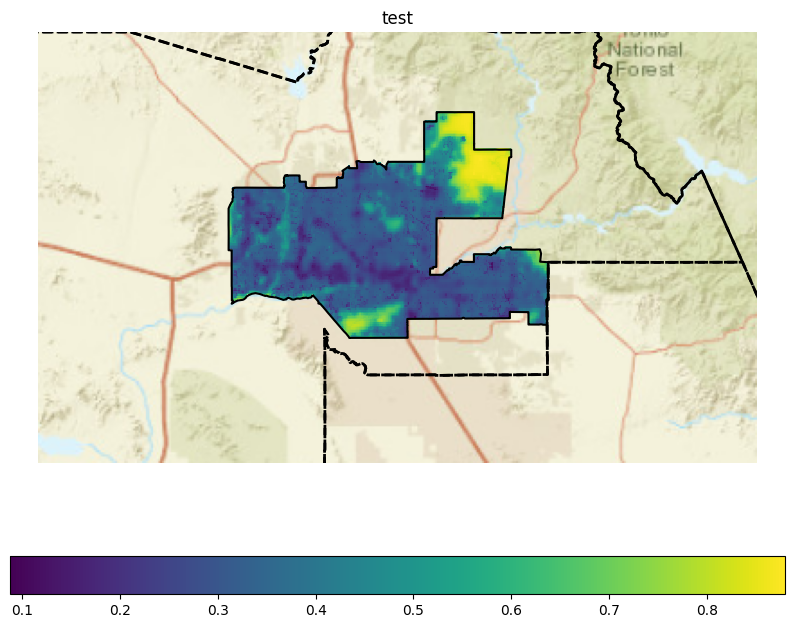

In [28]:
# plot raster with correct ratio
size = 6
aspect = phoenix_2017_rast_agg.rio.width / phoenix_2017_rast_agg.rio.height

# select RGB bands and plot
fig, ax = plt.subplots(figsize=(10,8))
ax.axis('off')

#cx.add_basemap(ax = ax, source = "data/phoenix_2017_rast_mask.tif")

bm = Basemap(projection='merc',
            resolution='c', llcrnrlon = -113, urcrnrlon = -111, llcrnrlat = 33, urcrnrlat = 34, epsg = 4269)

bm.drawcounties(ax = ax, linewidth = 2, linestyle = 'dashed')
bm.arcgisimage(ax = ax, service = 'World_Street_Map')


#x, y = bm(*np.meshgrid(phoenix_2017_rast_mask.x, phoenix_2017_rast_mask.y))
#cs = bm.pcolor(x,y,phoenix_2017_rast_mask.data)

#rioshow(phoenix_2017_rast_mask)
phoenix_2017_rast_mask.plot.imshow(ax = ax, cbar_kwargs = {'orientation': 'horizontal'})

#cx.add_basemap(ax = ax, crs = phoenix_2017_rast_mask.rio.crs, source = cx.providers.CartoDB.Voyager)

phoenix.boundary.plot(ax = ax, alpha = 1, color = 'black')

ax.set_title('test')


plt.show()

# [-115.3859782, 27.565314, -108.2066425, 34.7446497]

In [30]:
# Get the spatial resolution (cell size) 
resolution_x_2020 = abs(phoenix_2020_rast_mask.x[1] - phoenix_2020_rast_mask.x[0]) # Resolution in the x-direction 
resolution_y_2020 = abs(phoenix_2020_rast_mask.y[1] - phoenix_2020_rast_mask.y[0]) # Resolution in the y-direction 

cell_size_2020 = resolution_x_2020 * resolution_y_2020

resolution_x_2017 = abs(phoenix_2017_rast_mask.x[1] - phoenix_2017_rast_mask.x[0]) # Resolution in the x-direction 
resolution_y_2017 = abs(phoenix_2017_rast_mask.y[1] - phoenix_2017_rast_mask.y[0]) # Resolution in the y-direction 

# Calculate cell area (assuming uniform cell size) 
cell_size_2017 = resolution_x_2017 * resolution_y_2017

# Total area of rasters
phoenix_2017_area = phoenix_2017_rast_mask.sum().item() * cell_size_2017
phoenix_2020_area = phoenix_2020_rast_mask.sum().item() * cell_size_2020

In [31]:
phoenix_2017_bii_75 = phoenix_2017_rast_mask.where(phoenix_2017_rast_mask >= 0.75, drop = True)
phoenix_2020_bii_75 = phoenix_2020_rast_mask.where(phoenix_2020_rast_mask >= 0.75, drop = True)

phoenix_2017_bii_75_area = phoenix_2017_bii_75.sum().item() * cell_size_2017
phoenix_2020_bii_75_area = phoenix_2020_bii_75.sum().item() * cell_size_2020

In [33]:
phoenix_2017_pct_75 = (phoenix_2017_bii_75_area / phoenix_2017_area) * 100
phoenix_2020_pct_75 = (phoenix_2020_bii_75_area / phoenix_2020_area) * 100
[phoenix_2020_pct_75, phoenix_2017_pct_75]

[<xarray.DataArray ()>
 array(14.17609819)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(15.39518126)
 Coordinates:
     spatial_ref  int64 0]